# Method of simulated moments

Import the different libaries and the SMD module

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

In [2]:
%matplotlib inline
# reload module each time cell is run
%load_ext autoreload
%autoreload 2
from ModelSingles import SingleClass
import numpy as np
import matplotlib.pyplot as plt
import funs
import figs

In [3]:
import SimulatedMinimumDistance as SMD

# Prep

Function to make moments

In [6]:
def mom_fun(data):
    mask_mh = (data.states==6) | (data.states==8)
    mask_ml = (data.states==5) | (data.states==7)
    mask_fh = (data.states==1) | (data.states==3)
    mask_fl = (data.states==0) | (data.states==2)
    return np.hstack((np.nanmean(data.probs[:,mask_mh],axis=1),
                      np.nanmean(data.probs[:,mask_ml],axis=1),
                      np.nanmean(data.probs[:,mask_fh],axis=1),
                      np.nanmean(data.probs[:,mask_fl],axis=1)
                    ))*100

def weight_fun(data):
    mask_mh = (data.states==6) | (data.states==8)
    mask_ml = (data.states==5) | (data.states==7)
    mask_fh = (data.states==1) | (data.states==3)
    mask_fl = (data.states==0) | (data.states==2)
    std = np.hstack((np.nanstd(data.probs[:,mask_mh]*100,axis=1),
                     np.nanstd(data.probs[:,mask_ml]*100,axis=1),
                     np.nanstd(data.probs[:,mask_fh]*100,axis=1),
                     np.nanstd(data.probs[:,mask_fl]*100,axis=1)
                    ))
    return np.eye(len(std))*std

In [72]:
#finds obj_func value

def obj_print(dict_in):
    return dict_in['obj_func'].index(min(dict_in['obj_func']))
                                              
#smd_base.est_par_save['obj_func'].index((min(smd_base.est_par_save['obj_func'])))
#print(smd_base.est_par_save['alpha_0_female'][145])

Generate data

In [8]:
data = SingleClass(Na=190, poc=10, a_max=10, simN=40000, simT=20)
data.par.simStates = np.array(list(range(8))*5000)
data.solve()
data.simulate()

Generate moments

In [9]:
mom_data = mom_fun(data.sim)
weight = weight_fun(data.sim)

In [18]:
mom_data

array([0.00000000e+00, 2.60848698e-07, 1.00205105e-05, 3.19788438e+01,
       1.91887821e+01, 2.15294896e+01, 1.05999659e+01, 4.70528684e+00,
       1.94593865e+00, 1.66359041e+00, 1.18324813e+00, 8.47103760e-01,
       6.04875606e-01, 3.00375262e-01, 7.08568699e-02, 2.81769303e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.85440572e-07,
      

Estimate the baseline model

In [ ]:
model_base = SingleClass(Na=190, poc=10, a_max=10, simN=40000, simT=20)
model_base.par.simStates = np.array(list(range(8))*5000)
model_base.par.sim_seed = 2019
model_base._simulate_prep()

Check seed numbers form simulated data and model are not the same.

In [ ]:
# Different seeeds
print('data seed:',data.par.sim_seed)
print('estimation seed',model_base.par.sim_seed)

Jeg har indført et stykke kode SimulatedMinimumDistance.py - for at gemme objektiv funtionen og de forløbige estimater - det bruges så for at plotte estimeringen. 
Deruder har jeg indført et stykke kode i fig. for at plotte 3D grafer med de overstående lister.

# Estimate - without "multistart"

Setup for estimation

In [15]:
#The "true values from the model"
true = [data.par.alpha_0_female]#, data.par.alpha_0_male, data.par.alpha_1]
#Our "guess" values
theta0 = [i*1.5 for i in true]
add_str = '_est'
est_par = ["alpha_0_female"]#, "alpha_0_male", "alpha_1") # remember to be list if only 1 var

Estimation

In [ ]:
#sim
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=True,save=True,options={'disp':True})
smd_base.est_par = est_par

#Creates the dictionary to which we save the output from estimation
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

#run estimation
smd_base.estimate(theta0,weight)
theta_base = smd_base.est

theta_base - true

# "Multistart" estimation

Setup for estimation

In [ ]:
# prep
true = [model.par.alpha_0_female, model.par.alpha_1]#, model.par.alpha_2]
theta0 = [i*3 for i in true]
add_str = '_est'
est_par = ["alpha_0_female", "alpha_1"]#, "alpha_2") # remember to be list if only 1 var
est_par_g = {"alpha_0_female":[0,1], "alpha_1":[0,1]}#, "alpha_2":[3,4]}



Estimation

In [26]:
#sim
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=True,save=True,options={'disp':True})
smd_base.est_par = est_par

#Creates a list with a number of starting values for each parameter. 
guess = smd_base.multistart_V(2,est_par_g)

#Creates the dict to save output from estimation
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

#Run estimation
smd_base.multistart_estimate(guess,weight)
theta_base = smd_base.est


 alpha_0_female=0.949 alpha_1=0.903 -> 62729.6363
 alpha_0_female=0.997 alpha_1=0.903 -> 63846.2721
 alpha_0_female=0.949 alpha_1=0.948 -> 63574.0535
 alpha_0_female=0.902 alpha_1=0.948 -> 62525.4055
 alpha_0_female=0.854 alpha_1=0.971 -> 62115.1126
 alpha_0_female=0.854 alpha_1=0.926 -> 60924.3106
 alpha_0_female=0.807 alpha_1=0.914 -> 59344.4391
 alpha_0_female=0.712 alpha_1=0.982 -> 58465.6245
 alpha_0_female=0.593 alpha_1=1.022 -> 55319.3171
 alpha_0_female=0.546 alpha_1=0.965 -> 50265.0168
 alpha_0_female=0.392 alpha_1=0.962 -> 41291.0332
 alpha_0_female=0.178 alpha_1=1.070 -> 37877.3996
 alpha_0_female=-0.136 alpha_1=1.147 -> 48796.3091
 alpha_0_female=-0.024 alpha_1=1.010 -> 37568.8225
 alpha_0_female=-0.332 alpha_1=1.005 -> 42874.8284
 alpha_0_female=-0.237 alpha_1=1.118 -> 49248.3883
 alpha_0_female=0.234 alpha_1=1.001 -> 36144.1330
 alpha_0_female=0.033 alpha_1=0.942 -> 33024.6508
 alpha_0_female=-0.040 alpha_1=0.878 -> 33601.8280
 alpha_0_female=0.291 alpha_1=0.933 -> 35324.

# Figures

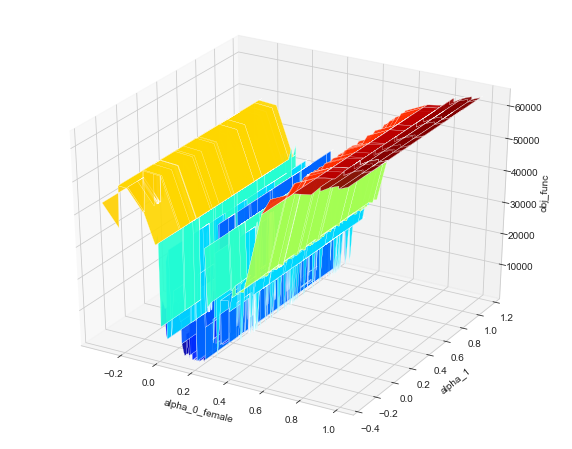

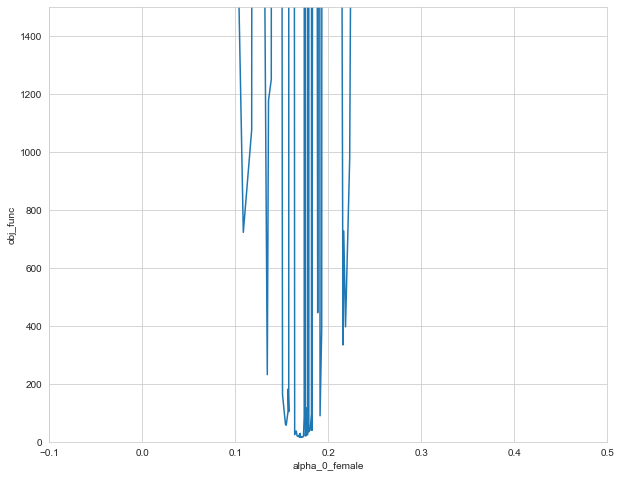

In [95]:
fig1 = figs.plot_3DD(smd_base.est_par_save,'alpha_0_female','alpha_1','obj_func')
#fig2 = figs.plot_3D(smd_base.est_par_save,'alpha_1','alpha_0_female','obj_func')
#fig3 = figs.plot_3D(smd_base.est_par_save,'alpha_1','obj_func','alpha_0_female')
#fig4 = figs.plot_3D(smd_base.est_par_save,'obj_func','alpha_0_female','alpha_1')

figs.plot_2DD(smd_base.est_par_save,'alpha_0_female','obj_func',[-0.1,0.5],[0,1500])